# Density from CO line ratios

December 8, 2023

Make 1D grids of CO 3-2/1-0 line ratio against density n. Fix Tex and N(CO) but have them adjustable for checking results.

The idea is that the line ratio is sensitive to density when the lines are optically thin; see the grids in `co_column_grid.ipynb`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from spectralradex import radex
import time

In [2]:
params = radex.get_default_parameters()

In [3]:
params

{'molfile': 'co.dat',
 'tkin': 30.0,
 'tbg': 2.73,
 'cdmol': 10000000000000.0,
 'h2': 100000.0,
 'h': 0.0,
 'e-': 0.0,
 'p-h2': 0.0,
 'o-h2': 0.0,
 'h+': 0.0,
 'linewidth': 1.0,
 'fmin': 0.0,
 'fmax': 1000.0,
 'geometry': 1}

In [4]:
# Copied these from co_column_grid.ipynb, very useful

# Functions operating on the full result DataFrame (3 lines: 1-0, 2-1, 3-2).
# Not using 2-1 line but expecting it to be there for indexing purposes.

def from_result_get_line_ratio(rdf):
    """
    3-2 / 1-0 line T_R ratio
    :param rdf: result DataFrame
    :returns: float line ratio
    """
    tr_col = rdf['T_R (K)']
    return tr_col.iloc[2] / tr_col.iloc[0]

def from_result_get_tau(rdf, line):
    """
    Optical depth of either 1-0 or 3-2 line, specified by 'line' argument
    :param rdf: result DataFrame
    :param line: int 10 or 32
    :returns: float optical depth for that line
    """
    # Get iloc index, we know in advance where these are in the DataFrame
    if line == 10:
        return rdf.iloc[0]['tau']
    elif line == 32:
        return rdf.iloc[2]['tau']
    else:
        raise RuntimeError(f"What line is <{line}>?")



def convert_nh2_to_co_isotope(nh2, isotope):
    # convert N(H2) to N(13CO) or N(C18O)
    n12co = nh2 * 8.5e-5 # Tielens book number
    if isotope == '13co':
        n13co = n12co / 44.65 # Karim et al. number
        return n13co
    elif isotope == 'c18o':
        nc18o = n12co / 417 # Wilson and Rood 1994
        return nc18o
    else:
        raise RuntimeError(f"isotope? {isotope}")

# Need different functions for running c18o and 13co simultaneously.
def run_13_and_18(param_dict, nh2):
    """
    Take in param dict and run radex for both 13co and c18o
    :param param_dict: params dictionary per spectralradex definition.
        All the important physical paramters should already be set.
        'molfile' will be edited by this function so its initial value
        in the dictionary is not important and will NOT be preserved.
        Same with the 'cdmol' param.
    :param nh2: the H2 column density. Uses our standard converters to get
        the correct isotopic co abundance
    :returns: a dict of both result dfs with the keys '13co' and 'c18o'
    """
    return_dict = {}
    for isotope in ['13co', 'c18o']:
        param_dict['molfile'] = isotope + '.dat'
        param_dict['cdmol'] = convert_nh2_to_co_isotope(nh2, isotope)
        return_dict[isotope] = radex.run(param_dict)
    return return_dict

def from_multi_df_result_get_line_ratio(rdf_dict):
    """
    3-2 / 1-0 line T_R ratio from 13co 3-2 and c18o 1-0
    :param rdf_dict: dict of rdfs with isotope keys
    :returns: float line ratio
    """
    tr_c18o10 = rdf_dict['c18o'].iloc[0]['T_R (K)']
    tr_13co32 = rdf_dict['13co'].iloc[2]['T_R (K)']
    return tr_13co32 / tr_c18o10

def from_multi_df_result_get_tau(rdf_dict, line):
    """
    Optical depth of either c18o 1-0 or 13co 3-2 line, specified by 'line' argument
    :param rdf_dict: dict of rdfs with isotope keys
    :param line: int 10 or 32
    :returns: float optical depth for that line
    """
    if line == 10:
        return rdf_dict['c18o'].iloc[0]['tau']
    elif line == 32:
        return rdf_dict['13co'].iloc[2]['tau']
    else:
        raise RuntimeError(f"What line is <{line}>?")

## Set TK and NH2

These won't change per run.

In [5]:
# Setup fixed but adjustable params
tk = 35. # K
nh2 = 9e22 / 2

## 13 CO only

The next block of code applies only to the case where we compare the 3-2 and 1-0 transitions of 13CO.

13CO column density 8.6E+16 from N(H2)=4.5E+22
manual grid took 0.2571 seconds without a pool


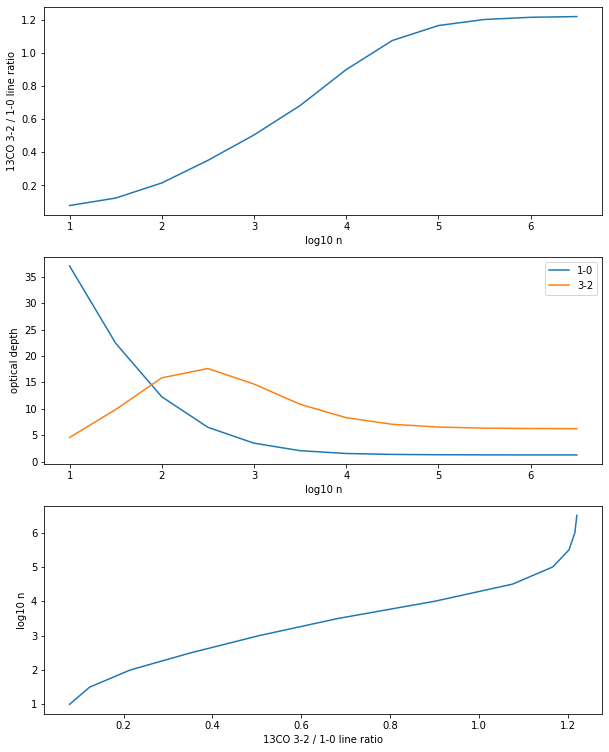

In [6]:
# convert N(H2) to N(13CO)
n13co = convert_nh2_to_co_isotope(nh2, '13co')

print(f"13CO column density {n13co:.1E} from N(H2)={nh2:.1E}")

# Setup fixed params
molfile = '13co.dat'
linewidth = 1. # km/s

params['cdmol'] = n13co
params['tkin'] = tk

params['fmin'] = 100.
params['fmax'] = 400.

params['linewidth'] = linewidth
params['molfile'] = molfile


# Define variable params
lognarr = np.arange(1, 7, 0.5)
n_arr = 10.**lognarr
result_list = []

# Run Radex in loop
tic = time.perf_counter()
for dens in n_arr:
    params['h2'] = dens
    result_list.append(radex.run(params))

toc = time.perf_counter()

print(f"manual grid took {toc-tic:0.4f} seconds without a pool")


tau10_arr = [from_result_get_tau(result, 10) for result in result_list]
tau32_arr = [from_result_get_tau(result, 32) for result in result_list]
line_ratio_arr = [from_result_get_line_ratio(result) for result in result_list]


plt.figure(figsize=(10, 13))
plt.subplot(311)
plt.plot(lognarr, line_ratio_arr)
plt.xlabel("log10 n")
plt.ylabel("13CO 3-2 / 1-0 line ratio")
plt.subplot(312)
plt.plot(lognarr, tau10_arr, label='1-0')
plt.plot(lognarr, tau32_arr, label='3-2')
plt.xlabel("log10 n")
plt.ylabel("optical depth")
plt.legend()
plt.subplot(313)
plt.plot(line_ratio_arr, lognarr)
plt.ylabel("log10 n")
plt.xlabel("13CO 3-2 / 1-0 line ratio");

## C18O 1-0 and 13CO 3-2

The next block of code applies to the case where we compare the 1-0 transition of C18O to the 3-2 transition of 13CO. This theoretically gives us better (lower) optical depth, since 13CO 1-0 can get sort of thick (see graphs above).

13CO column density 8.6E+16 from N(H2)=4.5E+22
C18O column density 9.2E+15 from N(H2)=4.5E+22
manual grid took 0.5186 seconds without a pool


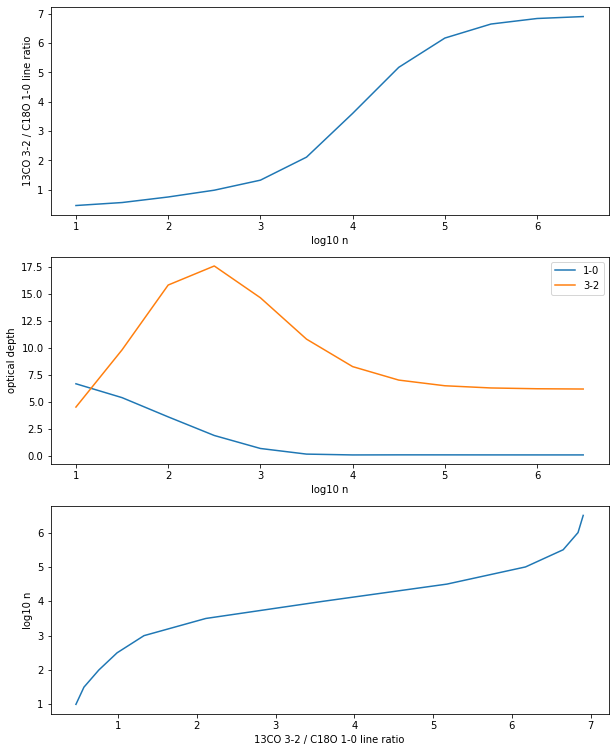

In [7]:
# convert N(H2) to N(13CO)
n13co = convert_nh2_to_co_isotope(nh2, '13co')
nc18o = convert_nh2_to_co_isotope(nh2, 'c18o')

print(f"13CO column density {n13co:.1E} from N(H2)={nh2:.1E}")
print(f"C18O column density {nc18o:.1E} from N(H2)={nh2:.1E}")

# Setup fixed params
linewidth = 1. # km/s

params['tkin'] = tk

params['fmin'] = 100.
params['fmax'] = 400.

params['linewidth'] = linewidth


# Define variable params
lognarr = np.arange(1, 7, 0.5)
n_arr = 10.**lognarr
result_list = []

# Run Radex in loop
tic = time.perf_counter()
for dens in n_arr:
    params['h2'] = dens
    result_list.append(run_13_and_18(params, nh2))

toc = time.perf_counter()

print(f"manual grid took {toc-tic:0.4f} seconds without a pool")


tau10_arr = [from_multi_df_result_get_tau(result, 10) for result in result_list]
tau32_arr = [from_multi_df_result_get_tau(result, 32) for result in result_list]
line_ratio_arr = [from_multi_df_result_get_line_ratio(result) for result in result_list]


plt.figure(figsize=(10, 13))
plt.subplot(311)
plt.plot(lognarr, line_ratio_arr)
plt.xlabel("log10 n")
plt.ylabel("13CO 3-2 / C18O 1-0 line ratio")
plt.subplot(312)
plt.plot(lognarr, tau10_arr, label='1-0')
plt.plot(lognarr, tau32_arr, label='3-2')
plt.ylabel("optical depth")
plt.xlabel("log10 n")
plt.legend()
plt.subplot(313)
plt.plot(line_ratio_arr, lognarr)
plt.xlabel("13CO 3-2 / C18O 1-0 line ratio")
plt.ylabel("log10 n");